In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


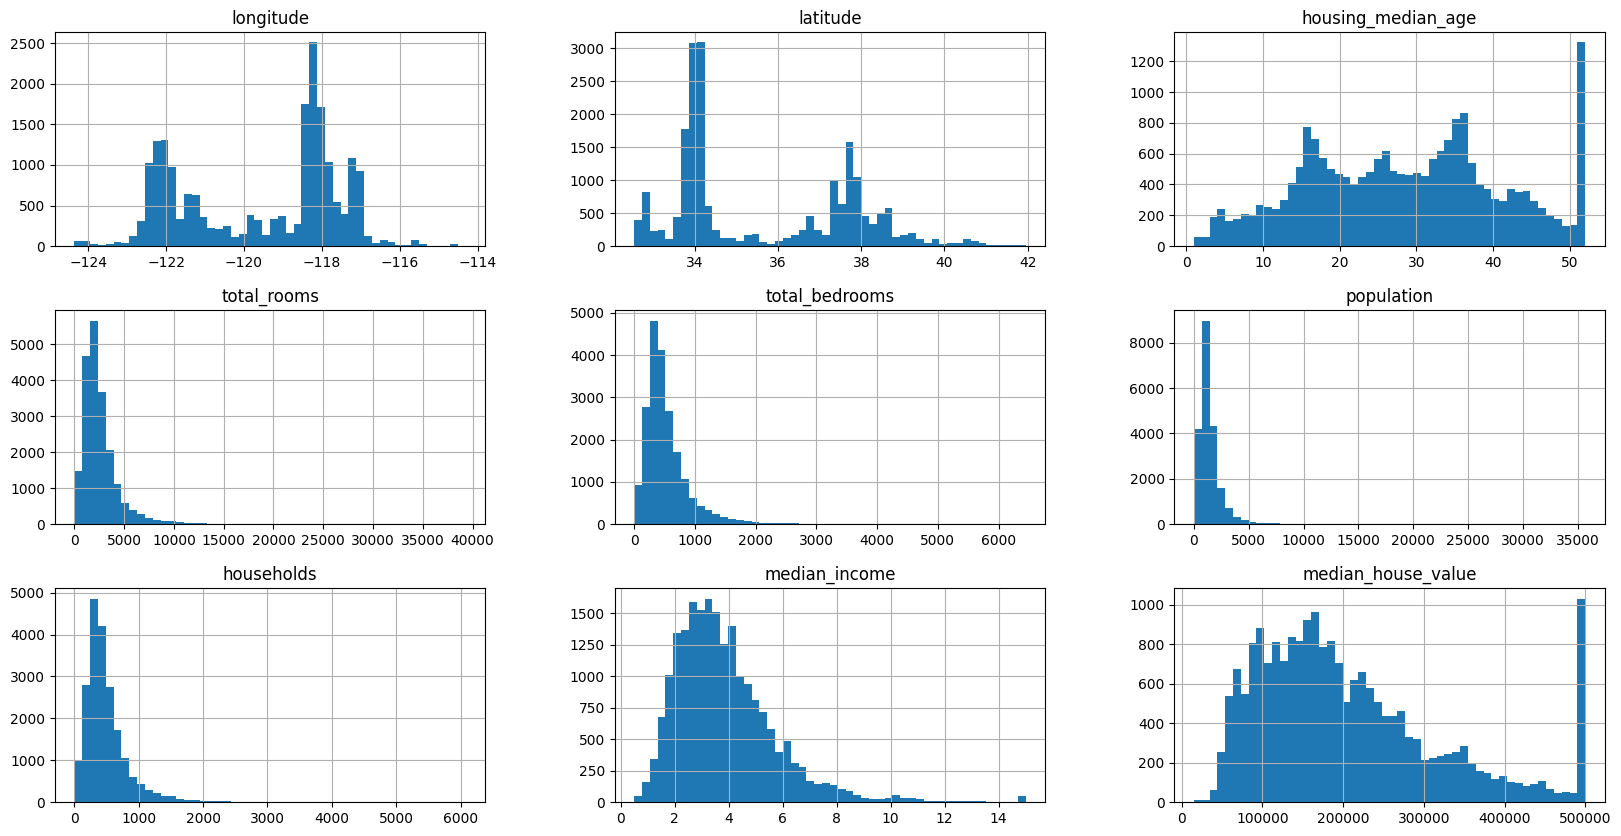

In [6]:
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20,10)) ## new code to possibly use
plt.show();

### Train and Test Split

In [7]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [9]:
from zlib import crc32
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [12]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 420)

In [13]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels = [1,2,3,4,5])

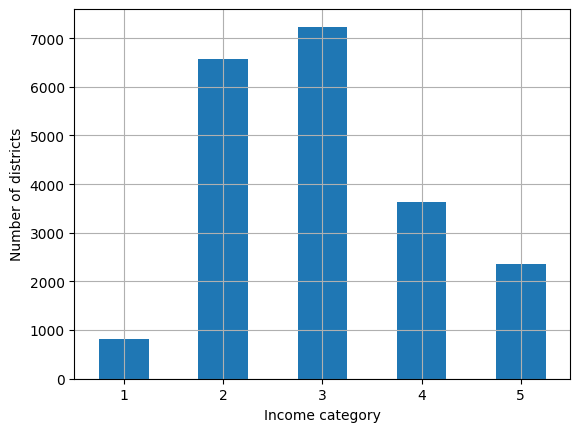

In [14]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show();

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 420)

strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [16]:
strat_train_set, strat_test_set = train_test_split(housing, test_size = 0.2, stratify = housing["income_cat"], random_state = 42)

In [17]:
len(strat_train_set),len(strat_test_set)

(16512, 4128)

In [18]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [19]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

,count
income_cat,
3,0.350594
2,0.318859
4,0.176296
5,0.114462
1,0.039789


In [20]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis = 1, inplace = True)

### Exploratory Data Analysis

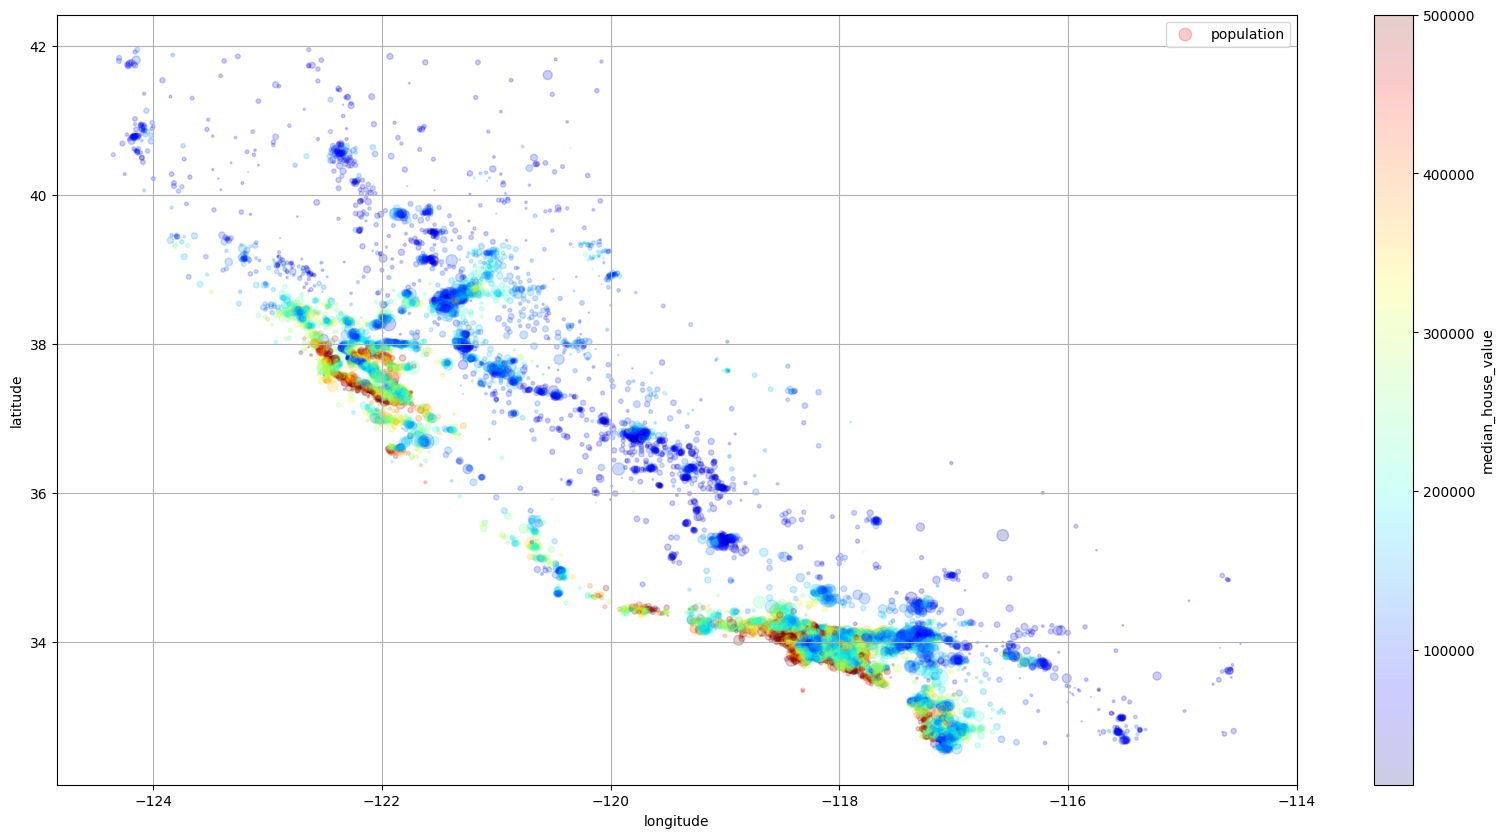

In [21]:
housing = strat_train_set.copy()
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, alpha = 0.2,
             s = housing["population"]/100, label = "population", c = "median_house_value",
             cmap = "jet", colorbar = True, legend = True, sharex = False, figsize = (20,10))
plt.show();

In [26]:
corr_matrix = housing.drop("ocean_proximity", axis = 1).corr()

In [27]:
import seaborn as sns; sns.set_style("dark")

<Axes: >

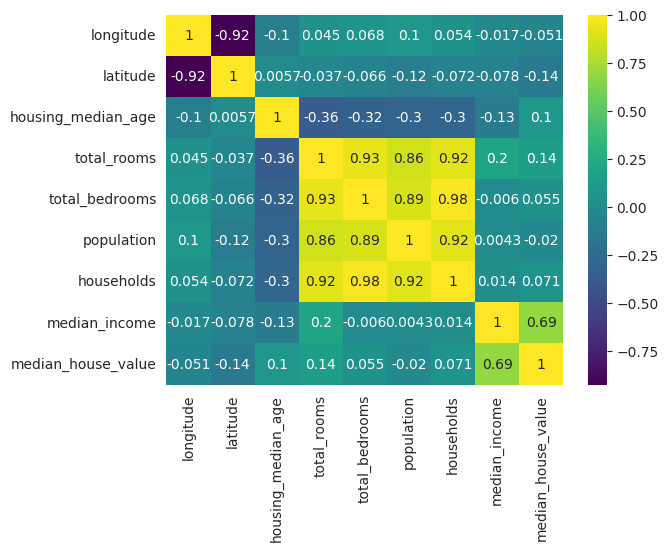

In [28]:
sns.heatmap(corr_matrix, annot = True, cmap = "viridis")

In [29]:
corr_matrix["median_house_value"].sort_values(ascending = False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
longitude,-0.050859
latitude,-0.139584


In [30]:
from pandas.plotting import scatter_matrix

In [31]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

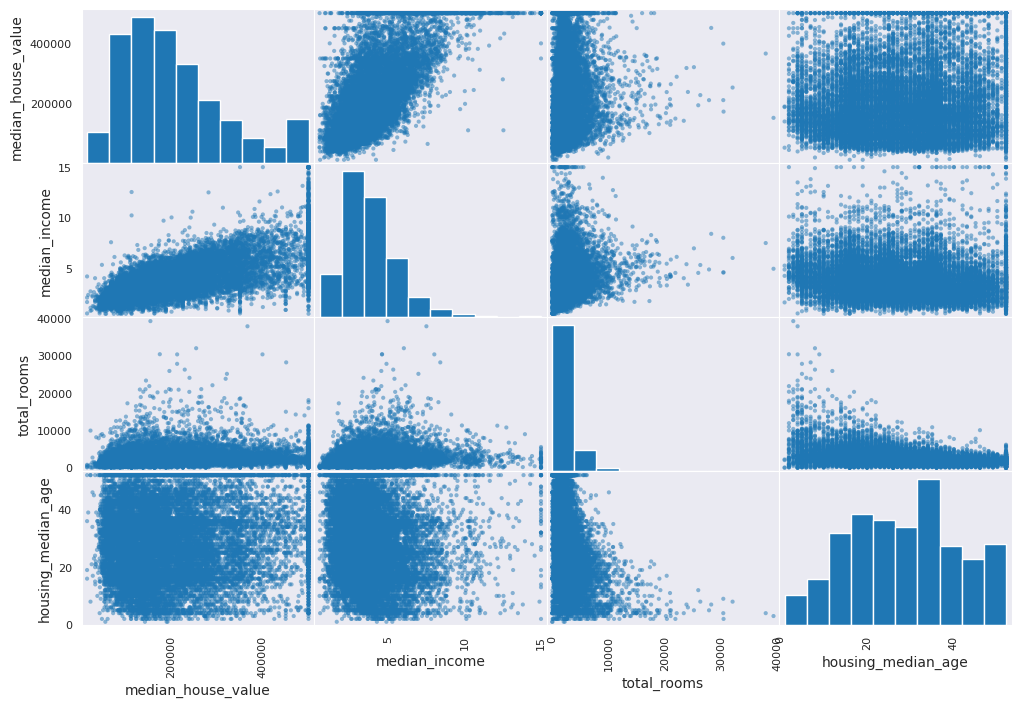

In [32]:
scatter_matrix(housing[attributes], figsize = (12,8))
plt.show()

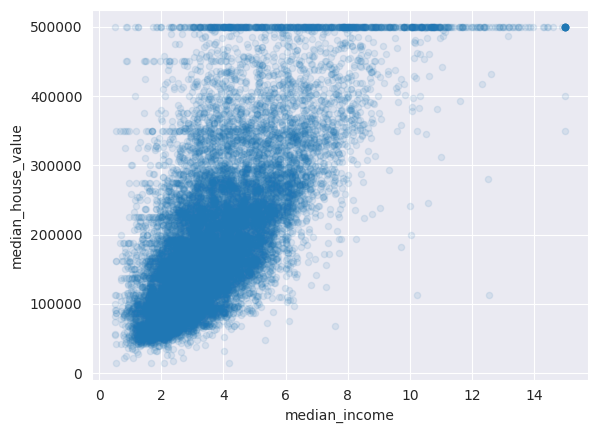

In [33]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

In [34]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [36]:
corr_matrix = housing.drop("ocean_proximity", axis = 1).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
population,-0.020153
people_per_house,-0.038224
longitude,-0.050859


### Data Preparation for Algorithmic Development

In [37]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [38]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median, inplace = True)

<ipython-input-38-abe3ec9d6a21>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"] = housing["total_bedrooms"].fillna(median, inplace = True)


In [39]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")

In [40]:
housing_num = housing.select_dtypes(include = [np.number])

In [41]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [42]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    , 1167.    ,  408.    ,
          3.5385])

In [43]:
X = imputer.transform(housing_num)

In [44]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

#### Handling Text and Categorical Attributes

In [45]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(9)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN


In [46]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [47]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [48]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [50]:
cat_encoder.transform(df_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (2, 5)>

In [51]:
cat_encoder.handle_unknown = "ignore"

In [52]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})

In [53]:
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [54]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [55]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

### Feature Scaling and Transformation

In [56]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [57]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [58]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [59]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [60]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [61]:
## Custom Transformer
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func = np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [62]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [63]:
## function transformers can also be used for hardcoded feature engineering
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

### Transformation Pipeline

In [65]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [66]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.69, -0.37,  1.17]])

In [67]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.273563,0.882868,0.145396


In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [69]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)


In [70]:
housing_prepared = preprocessing.fit_transform(housing)

In [71]:
preprocessing.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__population', 'pipeline-1__households',
       'pipeline-1__median_income', 'pipeline-2__total_bedrooms_None',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)

In [72]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [73]:
def column_ratio(X):
  return X[:,[0]]/X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
  return ["ratio"]

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy = "median"),
      FunctionTransformer(column_ratio, feature_names_out = ratio_name),
      MinMaxScaler()
  )

log_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                             FunctionTransformer(np.log, feature_names_out = "one-to-one"),
                             MinMaxScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     MinMaxScaler())

preprocessing = ColumnTransformer([
    #("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    #("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    #("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include = object))
], remainder = default_num_pipeline)

In [74]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,None,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,None,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,None,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,None,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,None,1912.0,1172.0,3.5292,NEAR OCEAN


In [75]:
housing_prepared = preprocessing.fit_transform(housing)

df_housing_prepared = pd.DataFrame(housing_prepared, columns = preprocessing.get_feature_names_out(), index = housing.index)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [76]:
df_housing_prepared.head()

,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,geo__Cluster 2 similarity,geo__Cluster 3 similarity,geo__Cluster 4 similarity,geo__Cluster 5 similarity,...,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__total_bedrooms_None,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
13096,0.750012,0.728324,0.808399,0.421786,4.581829e-01,1.241847e-14,8.141160e-02,3.434950e-24,3.329278e-07,2.095028e-04,...,9.770322e-01,2.382191e-08,3.819126e-18,1.0,0.0,0.0,0.0,1.0,0.0,1.000000
14973,0.696931,0.628173,0.684544,0.734873,6.511495e-10,9.579596e-01,8.649502e-14,2.712990e-02,3.992038e-02,2.078914e-04,...,1.260964e-13,1.103491e-01,3.547610e-01,1.0,1.0,0.0,0.0,0.0,0.0,0.764706
3785,0.636671,0.608432,0.618797,0.465241,3.432506e-01,4.261141e-15,4.483096e-01,1.041079e-24,5.084725e-08,4.108863e-04,...,7.303265e-01,2.508224e-08,2.669659e-18,1.0,0.0,1.0,0.0,0.0,0.0,0.627451
14689,0.773136,0.746647,0.775568,0.443790,2.244844e-15,2.704823e-01,2.813014e-19,4.649510e-01,5.823840e-05,1.595594e-07,...,5.201263e-20,1.712982e-03,8.874598e-01,1.0,0.0,1.0,0.0,0.0,0.0,0.313725
20507,0.777685,0.750794,0.822989,0.574592,1.090228e-11,9.422206e-01,6.016730e-16,1.092616e-01,9.773465e-03,1.371210e-05,...,1.048030e-15,2.568824e-02,5.279506e-01,1.0,0.0,0.0,0.0,0.0,1.0,0.686275


### Select and Train a Model

In [90]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('minmaxscaler',
                                                              MinMaxScaler())]),
                                   transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a814bdc7110>)])),
                ('linearregression', LinearRegression())])

In [91]:
housing_predictions = lin_reg.predict(housing)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [92]:
housing_predictions[:5].round(-2)

array([235000., 371500., 138300.,  89800., 326300.])

In [93]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [94]:
from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)

In [95]:
lin_rmse

69923.5153136017

In [96]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('minmaxscaler',
                                                              MinMaxScaler())]),
                                   transformers=[('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a814bdc7110>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [97]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [98]:
tree_rmse

0.0

In [99]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/p

In [100]:
tree_rmses

array([66319.61215276, 64805.85588656, 65004.09282114, 63214.39871005,
       66386.67213186, 68352.35380131, 63479.50968246, 64307.93632442,
       65327.06914138, 62646.2234338 ])

In [101]:
pd.Series(tree_rmses).describe()

,0
count,10.000000
mean,64984.372409
std,1718.016672
min,62646.223434
25%,63686.616343
50%,64904.974354
75%,66071.476400
max,68352.353801


In [102]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['total_bedrooms']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/p

In [103]:
pd.Series(forest_rmses).describe()

,0
count,10.000000
mean,47166.274216
std,792.841541
min,46137.824504
25%,46560.164099
50%,46965.210198
75%,47900.677237
max,48338.997314


### Grid Search

In [104]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')

In [105]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
grid_search.fit(housing, housing_labels)

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values("mean_test_score", ascending = False, inplace = True)

In [ ]:
grid_search.best_params_

### Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

In [ ]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
                 reverse=True)

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

In [ ]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

In [ ]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")